# ***Test sur le modèle le plus performant (LinearSVC sur la colonne contenant les textes tokenisés sans les noms des personnages) (3 tags)***

# Imports

In [ ]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

# Pour la visualisation des pipelines sklearn
set_config(display='diagram')


# Chargement des données

In [ ]:
# Création d'un dossier appelé data
!mkdir data
# Téléchargement du fichier dev dans le dossier data
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv
# Téléchargement du fichier test dans le dossier data
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_test.csv

--2025-03-21 21:25:46--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471015192 (449M) [text/plain]
Saving to: ‘data/fanfics_dev.csv’

fanfics_dev.csv     100%[===================>] 449.19M  23.6MB/s    in 20s     

2025-03-21 21:26:06 (22.7 MB/s) - ‘data/fanfics_dev.csv’ saved [471015192/471015192]

--2025-03-21 21:26:06--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_test.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138972746 (133M) [text/plain]
Saving to: ‘data/fanfics_test.csv’

fanfics_test.csv    100%[================

In [ ]:
# Lecture des fichiers
dtypes = {'title': 'object',
          'tokenised_no_chara': 'object',
          'tag': 'category'}

df_dev = pd.read_csv('data/fanfics_dev.csv', dtype=dtypes)
df_test = pd.read_csv('data/fanfics_test.csv', dtype=dtypes)

# Sélectionner uniquement les 3 principaux tags

In [ ]:
# Filtrer les données pour ne conserver que les trois tags d'intérêt
tags_of_interest = ['Fluff', 'Angst', 'Hurt/Comfort']
df_dev_filtre = df_dev[df_dev['tag'].isin(tags_of_interest)]

In [ ]:
# Données sources
X_dev = df_dev_filtre['tokenised_no_chara']

# Données à prédire
y_dev = df_dev_filtre.tag

# Vectorisation TF-IDF

In [ ]:
# Découpage des textes en listes de mots
def split_text(text) :
  # Les textes ayant déjà été pré-tokénisés, il suffit de les découper au niveau des espaces
  return text.split(' ')

In [ ]:
# Objet TfidfVectorizer
text_vectorizer = TfidfVectorizer(tokenizer=split_text, min_df=0.01)

# Utilisation de GridSearch pour chercher les meilleurs hyperparamètres

In [ ]:
# Définir les paramètres à tester
param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 10, 100],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__penalty': ['l2'],
    'linearsvc__tol': [1e-4, 1e-3, 1e-2]
}

# Créer la pipeline avec TF-IDF et LinearSVC
pipeline = make_pipeline(TfidfVectorizer(tokenizer=split_text), LinearSVC())

# GridSearchCV avec validation croisée 5-fold
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Lancer la recherche des meilleurs hyperparamètres
grid_search.fit(X_dev, y_dev)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

# Meilleur score obtenu
print("Meilleur F1-score:", grid_search.best_score_)


Meilleurs paramètres: {'linearsvc__C': 1, 'linearsvc__loss': 'squared_hinge', 'linearsvc__penalty': 'l2', 'linearsvc__tol': 0.0001}
Meilleur F1-score: 0.6757464220379532


### Entrainement du modèle avec ces hyperparamètres

In [ ]:
# Modèle à entraîner
model = LinearSVC(C=1, loss='squared_hinge', penalty='l2', tol=0.0001)

# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Création de la pipeline pour le modèle
model_pipeline = make_pipeline(text_vectorizer, model)

# Validation croisée
y_pred = model_selection.cross_val_predict(model_pipeline, X_dev, y_dev, cv=kfold)

# Affichage des résultats
print("LinearSVC")
print(classification_report(y_dev, y_pred))

# Calcul et affichage du F1-score macro
f1 = metrics.f1_score(y_dev, y_pred, average='macro')
print(f"Macro F1-score: {f1:.4f}")

LinearSVC
              precision    recall  f1-score   support

       Angst       0.75      0.68      0.71       727
       Fluff       0.80      0.71      0.75       617
Hurt/Comfort       0.63      0.76      0.69       716

    accuracy                           0.72      2060
   macro avg       0.73      0.71      0.72      2060
weighted avg       0.73      0.72      0.72      2060

Macro F1-score: 0.7179


On obtient exactement les mêmes résultats que précédemment (avec les paramètres par défaut).

Après plusieurs essai sur différents hyperparamètres, je n'arrive pas à obtenir de meilleurs résultats.

# Evaluation sur les données de test

### Préparation des données de test

In [ ]:
df_test_filtre = df_test[df_test['tag'].isin(tags_of_interest)]

In [ ]:
# Données sources
X_test = df_test_filtre['tokenised_no_chara']

# Données à prédire
y_test = df_test_filtre.tag

### Test et matrice de confusion

📊 Rapport de classification sur le Test Set:
              precision    recall  f1-score   support

       Angst       0.68      0.48      0.56       203
       Fluff       0.64      0.61      0.62       183
Hurt/Comfort       0.53      0.69      0.60       216

    accuracy                           0.60       602
   macro avg       0.62      0.60      0.60       602
weighted avg       0.61      0.60      0.60       602



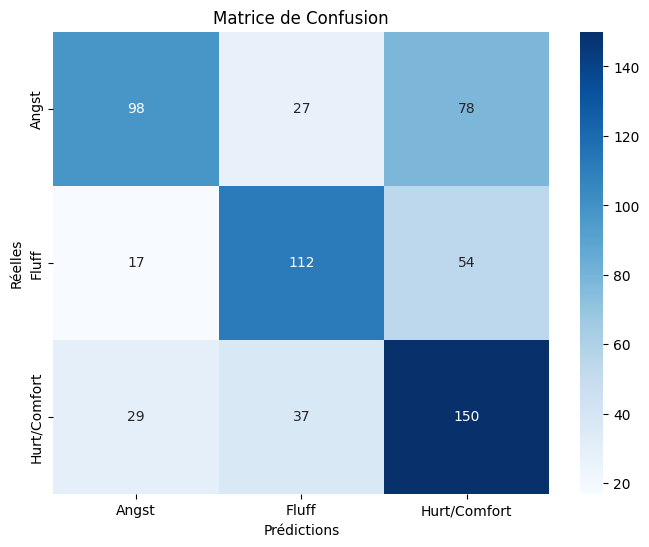

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Réentraîner le modèle sur tout le jeu de développement
model_pipeline.fit(X_dev, y_dev)

# Prédire sur le jeu de test
y_test_pred = model_pipeline.predict(X_test)

# Afficher le rapport de classification
print("📊 Rapport de classification sur le Test Set:")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 📌 Affichage sous forme de heatmap pour une meilleure lisibilité
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Réelles")
plt.title("Matrice de Confusion")
plt.show()


# Interprétation des résultats

### Caractéristiques discriminantes de chaque tag

In [ ]:
# Récupérer le vecteur de mots après vectorisation
feature_names = text_vectorizer.get_feature_names_out()

# Récupérer les coefficients du modèle
coefficients = model_pipeline.named_steps['linearsvc'].coef_

# Créer un dataframe avec les mots et leurs coefficients pour chaque tag
df_coeffs = pd.DataFrame(coefficients, columns=feature_names, index=model.classes_)

# Afficher les 10 mots les plus discriminants pour chaque tag
for tag in model.classes_:
    print(f"\n🔹 Top 15 mots pour {tag} :")
    print(df_coeffs.loc[tag].sort_values(ascending=False).head(15))



🔹 Top 15 mots pour Angst :
sang        1.908100
corps       1.766019
mort        1.575064
douleur     1.562957
rien        1.489408
devait      1.317362
savait      1.311192
bite        1.281137
tom         1.274485
mere        1.268177
empereur    1.265741
chose       1.254840
patron      1.238053
harry       1.199408
laissant    1.189386
Name: Angst, dtype: float64

🔹 Top 15 mots pour Fluff :
sourire      3.967126
sourit       2.285497
rire         1.956333
noel         1.886205
enfants      1.461641
d            1.433929
alpha        1.417320
-tu          1.385949
embrasser    1.351385
idee         1.325233
bal          1.263342
petit        1.255859
heureuse     1.185012
passer       1.183833
baiser       1.170681
Name: Fluff, dtype: float64

🔹 Top 15 mots pour Hurt/Comfort :
:             2.124088
larmes        1.691245
brun          1.486790
docteur       1.416067
sais          1.393456
maitre        1.355080
coeur         1.319932
ailleurs      1.271005
bras          1.217311
e

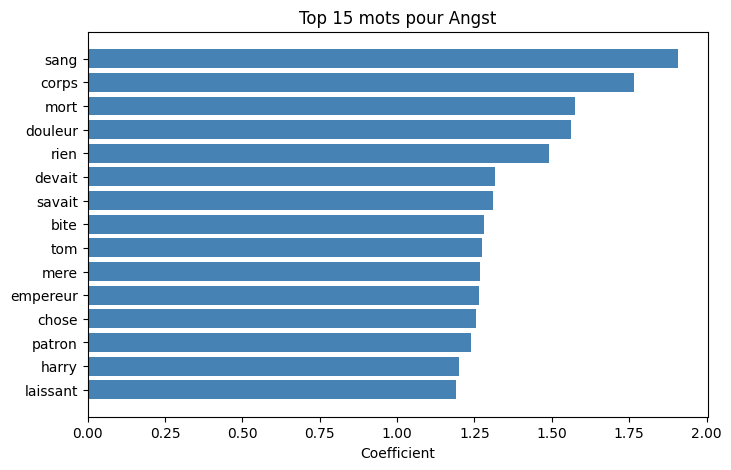

In [ ]:
def plot_top_words(tag, n=15):
    """ Affiche un graphique des mots les plus discriminants pour un tag donné. """
    top_words = df_coeffs.loc[tag].sort_values(ascending=False).head(n)
    plt.figure(figsize=(8,5))
    plt.barh(top_words.index, top_words.values, color='steelblue')
    plt.xlabel("Coefficient")
    plt.title(f"Top {n} mots pour {tag}")
    plt.gca().invert_yaxis()
    plt.show()

# Visualiser les mots les plus discriminants pour Angst
plot_top_words("Angst")


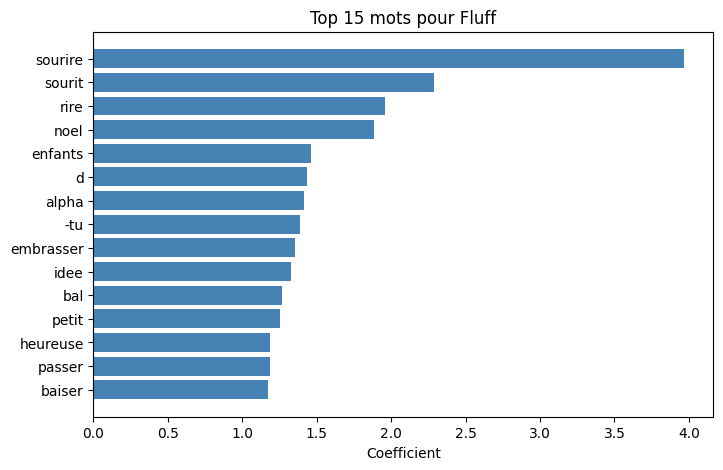

In [ ]:
# Visualiser les mots les plus discriminants pour Fluff
plot_top_words("Fluff")


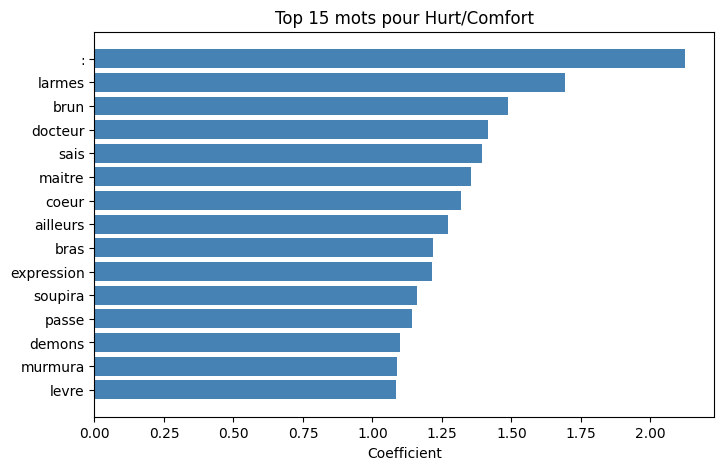

In [ ]:
# Visualiser les mots les plus discriminants pour Hurt/Comfort
plot_top_words("Hurt/Comfort")
